In [1]:
import efel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import funcs_for_ck2_sk_study as ephys
from scipy.signal import find_peaks
from scipy import signal
from scipy import stats
from scipy.optimize import curve_fit

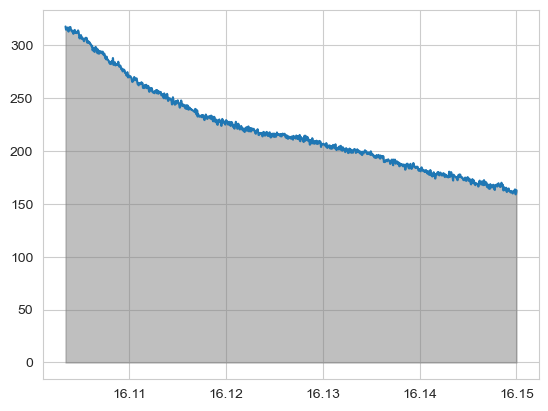

In [16]:
#these are the code to analyze the SK currents, an example of the voltage clamp data analysis. It will output the AHC max amplitude and AUC dor the entire tail current from the maximum point of the SK current to a specified end time. 

ahc_amp, ahc_auc = ephys.ahc_analysis_step_time(os.getcwd(), 16.1001, 16.15, '100ms step test')

In [17]:
ahc_auc

,Control AHC AUC (pA*s),file_name
0,20.497831,210708 005.axgd


In [18]:
ahc_amp

,Control AHC Max_Amplitude (pA),file_name
0,317.915039,210708 005.axgd
